In [ ]:
pip install pydicom

In [85]:
import pydicom
import os
import pandas as pd
import glob

# Exploratory Data Analysis

The dataset consists of multiple CT scans for 672 patients. These scans were performed using various parameters for Slice Thickness, Convolution Kernal, and Orientation. In order to run predictive models, we must use scans with consistent parameters. We must first determine which combination of these parameters is most suitable. 

## Identifying Scan Parameters from File Names

We first try to determine scan parameters by looking at their file names

In [ ]:
#makes dataframe of patient id's and associated scan types

def get_file_names():
    #loads all direcory names as list of strings
    entries = glob.glob("/datasets/*/*")
    entries.sort()
    
    #removes '/datasets/' from direcory strings
    entries = [entry[10:] for entry in entries]
    
    #splits directory strings on '/'
    split_entries = [entry.split('/') for entry in entries]
    
    #combines directory string lists with common patient id 
    output_dict = {}
    for key, *values in split_entries:
        if key not in output_dict:
            output_dict[key] = [key]
        output_dict[key].extend(values)
        
    unique_entries = list(output_dict.values())
    
    #makes of list of patient id and scan folder names
    unique_entries_final = [(unique_entry[0],unique_entry[1:]) for unique_entry in unique_entries]
    
    entries_df = pd.DataFrame(unique_entries_final, columns=['id', 'scans'])
    
    return entries_df

In [ ]:
entries_df = get_file_names()
entries_df

In [ ]:
from collections import Counter

#determine the muber of instances of each unique scan name
scan_counter = Counter()

for scan_list in entries_df["scans"]:
    for scan in scan_list:
        scan_counter[scan] += 1

print('The number of unique folder names is: ' + str(len(scan_counter)))

scan_counts_df = pd.DataFrame(scan_counter.most_common(), columns=['Scan Name', 'Number of Scans'])
with pd.option_context("display.max_rows", 10): 
    display(scan_counts_df)

Because of inconsistant file naming convenctions, there are over 200 unique file names for the scans of the 672 patients. The difficuty in determining parameter values for the individual scans based on these file names means another approach is necessary.

## Identifying Scan Parameters from Dicom Metadata

Each dicom file includes metadata pertaining to the scan that produced it. By looking at the metadata for each set of scans, we can determine which combination of parameter values to use for the training of our models. 

In [80]:
#make list of directories for first file in each folder 

import os

def get_first_file_in_every_folder(root_directory):
    first_files = []
    for dirpath, dirnames, filenames in os.walk(root_directory):
        if filenames:
            filenames.sort()
            first_file = os.path.join(dirpath, filenames[0])
            first_files.append(first_file)
    return first_files

root_directory = "/datasets"
first_files = get_first_file_in_every_folder(root_directory)

In [81]:
first_files.sort()

In [ ]:
first_files[-10:]

In [82]:
entries = glob.glob("/datasets/*/*")
entries.sort()
#entries[-10:]

In [83]:
first_files.remove('/datasets/Code_book.xlsx')

'/datasets/Code_book.xlsx' in first_files

False

In [86]:
#make list of dicom files based on list of directories

first_diacom_per_file = []

for scan in first_files:
        first_diacom_per_file.append(pydicom.dcmread(scan,force=True))

In [87]:
print(len(first_diacom_per_file))

5397


In [88]:
print(len(first_files))

5397


In [89]:
#remove files that cause error

del first_diacom_per_file[719]
del first_diacom_per_file[3771]
del first_diacom_per_file[4735]

In [90]:
print(len(first_diacom_per_file))

5394


In [92]:
#remove files that cause error

del first_files[719]
del first_files[3771]
del first_files[4735]

In [93]:
print(len(first_files))

5394


In [94]:
#check metadata of first dicom file 

first_diacom_per_file[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 188
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.12.2.1107.5.1.4.51964.30000016050615035692100000102
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.38'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'LOCALIZER', 'CT_SOM5 TOP']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.1.4.51964.30000016050615035692100000102
(0008, 0020) Study Date      

In [95]:
first_diacom_per_file[0].PatientID

'2460458378'

In [96]:
#make a list of desired dicom metadata properties

dicom_metadata_list = []
index = 0

for diacom in first_diacom_per_file:
    dicom_metadata_list.append([diacom.AccessionNumber, diacom.SliceThickness, diacom.ConvolutionKernel,
                                diacom.ImageOrientationPatient, diacom.PatientID, index])
    index += 1

In [98]:
diacom_metadata_df = pd.DataFrame(dicom_metadata_list, columns=['AccessionNumber', 'SliceThickness', 'ConvolutionKernel'
                                                               ,'ImageOrientationPatient', 'Patient ID', "Directory Index"])
diacom_metadata_df.head(20)

,AccessionNumber,SliceThickness,ConvolutionKernel,ImageOrientationPatient,Patient ID,Directory Index
0,1005053246,1.0,T20s,"[1, 6.123031769e-017, 0, 0, 0, -1]",2460458378,0
1,1005053246,1.0,B50f,"[1, 0, 0, 0, 1, 0]",2460458378,1
2,1005053246,3.0,B50f,"[1, 0, 0, 0, 1, 0]",2460458378,2
3,1005053246,10.0,B50f,"[1, 1.224606354e-016, -7.10542736e-015, -1.224...",2460458378,3
4,1005053246,10.0,B50f,"[1, 0, 0, 0, 0, -1]",2460458378,4
5,1005053246,2.0,B50f,"[1, 0, 0, 0, 0, -1]",2460458378,5
6,1005053246,10.0,B50f,"[6.123031769e-017, 1, 0, 0, 0, -1]",2460458378,6
7,1005053246,2.0,B50f,"[6.123031769e-017, 1, 0, 0, 0, -1]",2460458378,7
8,1005692582,1.0,B45f,"[1, 0, 0, 0, 1, 0]",2467550964,8
9,1005692582,10.0,B45f,"[1, 0, 0, 0, 1, 0]",2467550964,9


In [99]:
#function to determine ct orientation based on 'ImageOrientationPatient' column

def ct_orientation(index):

    image_orientation_patient_string = str(diacom_metadata_df['ImageOrientationPatient'].iloc[index])
    image_vectors = image_orientation_patient_string.replace('[','').replace(']','').split(',')
    image_vectors = [round(float(x)) for x in image_vectors]

    #[1,0,0,0,1,0]
    if image_vectors[0] == 1 and image_vectors[4] == 1: 
        return 'axial'
    
    #[0,1,0,0,0,-1]
    elif image_vectors[1] == 1 and image_vectors[5] == -1: 
        return 'sagittal'
    
    #[1,0,0,0,0,-1]
    elif image_vectors[0] == 1 and image_vectors[5] == -1: 
        return 'coronal'
    
    else:
        return 'unknown'

In [100]:
#add column for scan orientation

orientation = []
for index in range(len(diacom_metadata_df)):
    orientation.append(ct_orientation(index))
    
diacom_metadata_df['Orientation'] = orientation
diacom_metadata_df.head(10)

,AccessionNumber,SliceThickness,ConvolutionKernel,ImageOrientationPatient,Patient ID,Directory Index,Orientation
0,1005053246,1.0,T20s,"[1, 6.123031769e-017, 0, 0, 0, -1]",2460458378,0,coronal
1,1005053246,1.0,B50f,"[1, 0, 0, 0, 1, 0]",2460458378,1,axial
2,1005053246,3.0,B50f,"[1, 0, 0, 0, 1, 0]",2460458378,2,axial
3,1005053246,10.0,B50f,"[1, 1.224606354e-016, -7.10542736e-015, -1.224...",2460458378,3,axial
4,1005053246,10.0,B50f,"[1, 0, 0, 0, 0, -1]",2460458378,4,coronal
5,1005053246,2.0,B50f,"[1, 0, 0, 0, 0, -1]",2460458378,5,coronal
6,1005053246,10.0,B50f,"[6.123031769e-017, 1, 0, 0, 0, -1]",2460458378,6,sagittal
7,1005053246,2.0,B50f,"[6.123031769e-017, 1, 0, 0, 0, -1]",2460458378,7,sagittal
8,1005692582,1.0,B45f,"[1, 0, 0, 0, 1, 0]",2467550964,8,axial
9,1005692582,10.0,B45f,"[1, 0, 0, 0, 1, 0]",2467550964,9,axial


In [101]:
#example of folder containing different coordinate types

diacom_metadata_df.loc[diacom_metadata_df['AccessionNumber'] == '2916785364']

,AccessionNumber,SliceThickness,ConvolutionKernel,ImageOrientationPatient,Patient ID,Directory Index,Orientation
3323,2916785364,NaN,Tr20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",1998834231,3323,coronal
3324,2916785364,1.0,"[Br49d, 3]","[1, 0, 0, 0, 1, 0]",1998834231,3324,axial
3325,2916785364,1.0,Br49d,"[1, 0, 0, 0, 1, 0]",1998834231,3325,axial
3326,2916785364,10.0,Br49d,"[0.99891122848408, -0.016735876424, -0.0435461...",1998834231,3326,axial
3327,2916785364,10.0,Br49d,"[0.99891122848408, -0.016735876424, -0.0435461...",1998834231,3327,coronal
3328,2916785364,10.0,Br49d,"[0.016751766015, 0.99985967932274, 0, -0.00603...",1998834231,3328,sagittal
3329,2916785364,2.0,Br49d,"[0.99891122848408, -0.016735876424, -0.0435461...",1998834231,3329,coronal
3330,2916785364,2.0,Br49d,"[0.016751766015, 0.99985967932274, 0, -0.04354...",1998834231,3330,sagittal
3331,2916785364,3.0,Br49d,"[1, 0, 0, 0, 1, 0]",1998834231,3331,axial


In [102]:
#unique_slice_thickness = diacom_metadata_df['SliceThickness'].unique()
#print(unique_slice_thickness)

print('The unique Slice Thickness values and their counts are:')
diacom_metadata_df['SliceThickness'].value_counts()

The unique Slice Thickness values and their counts are:


SliceThickness
10.0    1977
2.0     1315
1.0      818
3.0      676
0.6       99
9.6        1
Name: count, dtype: int64

<Axes: title={'center': 'Slice Thickness Frequency'}, xlabel='Slice Thickness'>

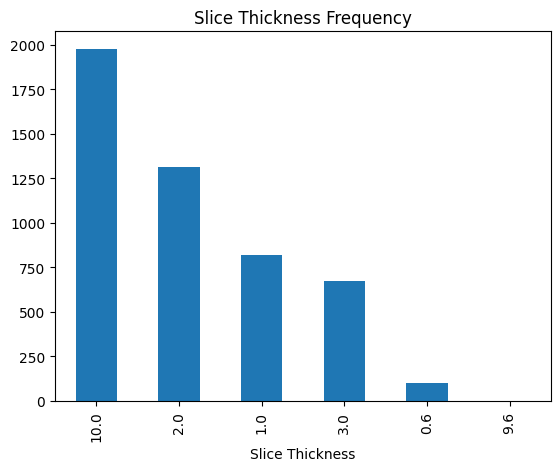

In [103]:
diacom_metadata_df['SliceThickness'].value_counts().plot(kind='bar', xlabel ='Slice Thickness', title = 'Slice Thickness Frequency')

In [104]:
#unique_convolution_kernal = diacom_metadata_df['ConvolutionKernel'].explode().unique()
#print(unique_convolution_kernal)
print('The unique Convolution Kernel values and their counts are:')
diacom_metadata_df['ConvolutionKernel'].value_counts()

The unique Convolution Kernel values and their counts are:


ConvolutionKernel
B45f          3679
T20f           532
Br49d          525
B46f           255
B50f           185
Tr20f           75
[Br49d, 3]      74
T20s            67
B35f             1
B30s             1
Name: count, dtype: int64

<Axes: title={'center': 'Convolution Kernel Frequency'}, xlabel='Convolution Kernel'>

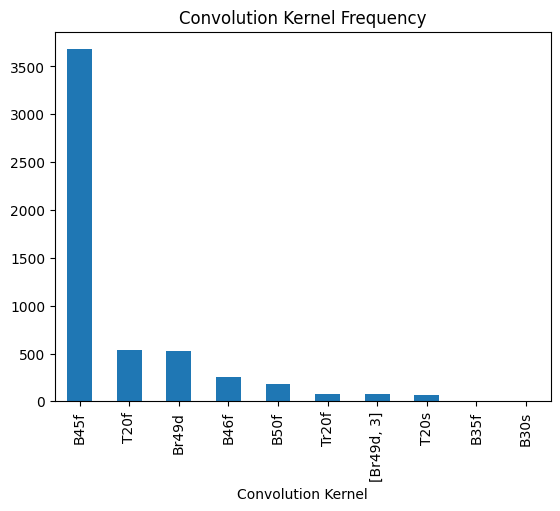

In [105]:
diacom_metadata_df['ConvolutionKernel'].value_counts().plot(kind='bar', xlabel ='Convolution Kernel', title = 'Convolution Kernel Frequency')

In [106]:
#unique_orientation = set(diacom_metadata_df['Orientation'])
#print(unique_orientation)
print('The unique Orientation values and their counts are:')
diacom_metadata_df['Orientation'].value_counts()

The unique Orientation values and their counts are:


Orientation
axial       2323
coronal     1970
sagittal    1098
unknown        3
Name: count, dtype: int64

<Axes: title={'center': 'Orientation Frequency'}, xlabel='Orientation'>

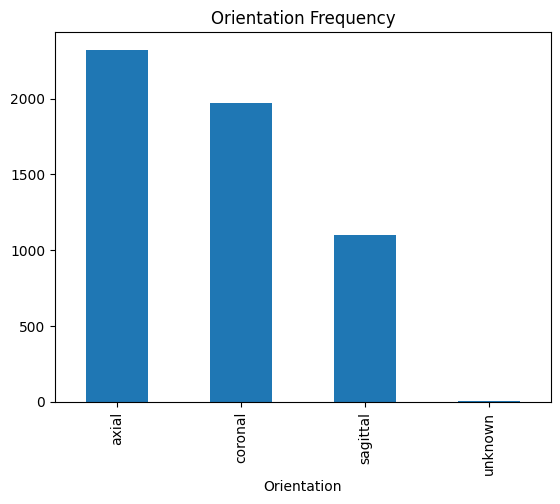

In [107]:
diacom_metadata_df['Orientation'].value_counts().plot(kind='bar', xlabel ='Orientation', title = 'Orientation Frequency')

In [108]:
#check number of rows that have a null value

print(diacom_metadata_df.isnull().sum())

AccessionNumber              0
SliceThickness             508
ConvolutionKernel            0
ImageOrientationPatient      0
Patient ID                   0
Directory Index              0
Orientation                  0
dtype: int64


In [109]:
#make dataframe of rows with null value 

nan_mask = pd.isnull(diacom_metadata_df).any(axis=1)
nan_df = diacom_metadata_df[nan_mask]

In [110]:
nan_df.tail(10)

,AccessionNumber,SliceThickness,ConvolutionKernel,ImageOrientationPatient,Patient ID,Directory Index,Orientation
5313,9352202043,NaN,T20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",1106309862,5313,coronal
5328,9383866191,NaN,T20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",3363087039,5328,coronal
5329,9404267413,NaN,T20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",2336620092,5329,coronal
5337,9421256107,NaN,T20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",2449579961,5337,coronal
5345,9658298987,NaN,T20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",2524892927,5345,coronal
5353,9705401851,NaN,T20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",3832132434,5353,coronal
5361,9820417218,NaN,Tr20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",6117165282,5361,coronal
5370,9842687566,NaN,T20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",1536615107,5370,coronal
5378,9954178646,NaN,T20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",3200298660,5378,coronal
5386,9971061671,NaN,T20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",9903677335,5386,coronal


In [111]:
#entries with null slice thickness are contained in folders entitled 'Topo'

diacom_metadata_df.loc[diacom_metadata_df['AccessionNumber'] == '1021652756']

,AccessionNumber,SliceThickness,ConvolutionKernel,ImageOrientationPatient,Patient ID,Directory Index,Orientation
32,1021652756,1.0,B45f,"[1, 0, 0, 0, 1, 0]",3398671109,32,axial
33,1021652756,10.0,B45f,"[1, 0, 0, 0, 0, -1]",3398671109,33,coronal
34,1021652756,10.0,B45f,"[0.010626396151, 0.99994353825846, 0, 0, 0, -1]",3398671109,34,sagittal
35,1021652756,10.0,B45f,"[0.9999867451123, -0.005148747392, 0, 0, 0, -1]",3398671109,35,coronal
36,1021652756,2.0,B45f,"[1, 0, 0, 0, 1, 0]",3398671109,36,axial
37,1021652756,2.0,B45f,"[1, 0, 0, 0, 1, 0]",3398671109,37,axial
38,1021652756,3.0,B45f,"[1, 0, 0, 0, 1, 0]",3398671109,38,axial
39,1021652756,NaN,T20f,"[1, 6.123233996e-017, 0, 0, 0, -1]",3398671109,39,coronal


In [112]:
#make new dataframe ommiting null values
diacom_no_nans_df = diacom_metadata_df[~diacom_metadata_df.isnull().any(axis=1)]

print(diacom_no_nans_df.isnull().sum())

AccessionNumber            0
SliceThickness             0
ConvolutionKernel          0
ImageOrientationPatient    0
Patient ID                 0
Directory Index            0
Orientation                0
dtype: int64


In [113]:
#cast 'ConvolutionKernel' to string to deal with ['Br49d', '3'] value
diacom_no_nans_df['ConvolutionKernel'] = diacom_no_nans_df['ConvolutionKernel'].astype(str)

#calculate the counts for different combinations of features
feature_count_df = diacom_no_nans_df.groupby(['SliceThickness','ConvolutionKernel', 'Orientation']).size().reset_index().rename(columns={0:'count'})

/tmp/ipykernel_2649269/43587305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diacom_no_nans_df['ConvolutionKernel'] = diacom_no_nans_df['ConvolutionKernel'].astype(str)


In [114]:
feature_count_df = feature_count_df.sort_values('count', ascending=False)

In [115]:
feature_count_df.head(10)

,SliceThickness,ConvolutionKernel,Orientation,count
29,10.0,B45f,axial,579
30,10.0,B45f,coronal,560
2,1.0,B45f,axial,531
21,3.0,B45f,axial,530
11,2.0,B45f,coronal,466
31,10.0,B45f,sagittal,445
12,2.0,B45f,sagittal,402
10,2.0,B45f,axial,166
0,0.6,T20f,coronal,98
40,10.0,Br49d,sagittal,88


In [116]:
#want entries with following properties:
#SliceThickness = 1.0, ConvolutionKernel = B45f, Orientation = axial
#this is the one used

reduced_df = diacom_metadata_df[(diacom_metadata_df['SliceThickness'] == 1.0) & (diacom_metadata_df['Orientation'] == 'axial')
                               & (diacom_metadata_df['ConvolutionKernel'] == 'B45f')]

In [117]:
#check entries with following properties:
#SliceThickness = 2.0, ConvolutionKernel = B45f, Orientation = axial

reduced_df_2 = diacom_metadata_df[(diacom_metadata_df['SliceThickness'] == 2.0) & (diacom_metadata_df['Orientation'] == 'axial')
                               & (diacom_metadata_df['ConvolutionKernel'] == 'B45f')]

In [118]:
reduced_df_2

,AccessionNumber,SliceThickness,ConvolutionKernel,ImageOrientationPatient,Patient ID,Directory Index,Orientation
29,1014372919,2.0,B45f,"[1, 0, 0, 0, 1, 0]",1708720103,29,axial
36,1021652756,2.0,B45f,"[1, 0, 0, 0, 1, 0]",3398671109,36,axial
37,1021652756,2.0,B45f,"[1, 0, 0, 0, 1, 0]",3398671109,37,axial
128,1054520186,2.0,B45f,"[1, 0, 0, 0, 1, 0]",1071989971,128,axial
142,1058371759,2.0,B45f,"[0.99929533920918, -1.5085106e-005, -0.0375343...",1756388016,142,axial
...,...,...,...,...,...,...,...
5237,8886763136,2.0,B45f,"[1, 0, 0, 0, 1, 0]",2988855850,5237,axial
5238,8886763136,2.0,B45f,"[1, 0, 0, 0, 1, 0]",2988855850,5238,axial
5358,9705401851,2.0,B45f,"[1, 0, 0, 0, 1, 0]",3832132434,5358,axial
5383,9954178646,2.0,B45f,"[1, 0, 0, 0, 1, 0]",3200298660,5383,axial


In [119]:
#check if reduced_df_2 contains patients contained in reduced_df

common_values = set(reduced_df_2['AccessionNumber']).intersection(set(reduced_df['AccessionNumber']))
print(set(reduced_df_2['AccessionNumber']).issubset(set(reduced_df['AccessionNumber'])))

True


In [120]:
total_patients = set(reduced_df_2['AccessionNumber'])
len(total_patients)

112

In [121]:
#check features of ommited patients

#creates dataframe of patients not included in other dataset
test_df = diacom_no_nans_df[~diacom_no_nans_df['AccessionNumber'].isin(reduced_df['AccessionNumber'].tolist())]
test_feature_count_df = test_df.groupby(['SliceThickness','ConvolutionKernel', 'Orientation']).size().reset_index().rename(columns={0:'count'})
test_feature_count_df = test_feature_count_df.sort_values('count', ascending=False)
test_feature_count_df

,SliceThickness,ConvolutionKernel,Orientation,count
28,10.0,Br49d,sagittal,88
3,1.0,Br49d,axial,75
19,3.0,Br49d,axial,75
27,10.0,Br49d,coronal,74
6,1.0,"['Br49d', '3']",axial,74
5,1.0,T20s,coronal,67
12,2.0,Br49d,coronal,62
26,10.0,Br49d,axial,62
13,2.0,Br49d,sagittal,62
21,10.0,B46f,coronal,39


In [122]:
#check features of additional ommited patients

#creates dataframe of patients not included in other datasets
test_df = diacom_no_nans_df[~diacom_no_nans_df['AccessionNumber'].isin(combined_accession_num_set)]
test_feature_count_df = test_df.groupby(['SliceThickness','ConvolutionKernel', 'Orientation']).size().reset_index().rename(columns={0:'count'})
test_feature_count_df = test_feature_count_df.sort_values('count', ascending=False)
test_feature_count_df

NameError: name 'combined_accession_num_set' is not defined

In [ ]:
#check features of additional ommited patients

#creates dataframe of patients not included in other datasets
test_df = diacom_no_nans_df[~diacom_no_nans_df['AccessionNumber'].isin(combined_accession_num_set)]
test_feature_count_df = test_df.groupby(['SliceThickness','ConvolutionKernel', 'Orientation']).size().reset_index().rename(columns={0:'count'})
test_feature_count_df = test_feature_count_df.sort_values('count', ascending=False)
test_feature_count_df

In [ ]:
#check entries with following properties:
#SliceThickness = 2.0, ConvolutionKernel = Br49d, ['Br49d', '3'], Orientation = axial

reduced_df_br49d = test_df[(test_df['SliceThickness'] == 1.0) & (test_df['Orientation'] == 'axial')
                               & (test_df['ConvolutionKernel'] == 'Br49d')]

reduced_df_br49d_3 = test_df[(test_df['SliceThickness'] == 1.0) & (test_df['Orientation'] == 'axial')
                               & (test_df['ConvolutionKernel'] == "['Br49d', '3']")]
reduced_df_b46f = test_df[(test_df['SliceThickness'] == 1.0) & (test_df['Orientation'] == 'axial')
                               & (test_df['ConvolutionKernel'] == "B46f")]
reduced_df_b50f = test_df[(test_df['SliceThickness'] == 1.0) & (test_df['Orientation'] == 'axial')
                               & (test_df['ConvolutionKernel'] == "B50f")]

In [ ]:
#check entries with following properties:
#SliceThickness = 10.0, ConvolutionKernel = Br49d, Orientation = axial

reduced_df_br49d_10 = test_df[(test_df['SliceThickness'] == 10.0) & (test_df['Orientation'] == 'axial')
                               & (test_df['ConvolutionKernel'] == 'Br49d')]
reduced_df_br49d_10

In [ ]:
reduced_df

In [ ]:
#make list of directories of scans with desired properties

reduced_directory_index = reduced_df['Directory Index'].tolist()

reduced_directory_list = []

for index in reduced_directory_index:
    reduced_directory_list.append(first_files[index])

In [ ]:
#make list of directories of scans with desired properties
#additional scans with br49d convolution kernel

reduced_directory_index_br49d = reduced_df_br49d['Directory Index'].tolist()
reduced_directory_list_br49d = []

for index in reduced_directory_index_br49d:
    reduced_directory_list_br49d.append(first_files[index])

In [ ]:
#make list of directories of scans with desired properties
#additional scans with b46f convolution kernel

reduced_directory_index_b46f = reduced_df_b46f['Directory Index'].tolist()
reduced_directory_list_b46f = []

for index in reduced_directory_index_b46f:
    reduced_directory_list_b46f.append(first_files[index])

In [ ]:
#make list of directories of scans with desired properties
#additional scans with b46f convolution kernel

reduced_directory_index_b50f = reduced_df_b50f['Directory Index'].tolist()
reduced_directory_list_b50f = []

for index in reduced_directory_index_b50f:
    reduced_directory_list_b50f.append(first_files[index])

In [ ]:
reduced_directory_list_b50f[0:10]

In [ ]:
reduced_directory_list[0:10]

In [ ]:
#removes diacom suffix from directories
reduced_directory_list_br49d_final = [directory[:directory.rindex('/')] for directory in reduced_directory_list_br49d]
reduced_directory_list_br49d_final[0:10]

In [ ]:
#removes diacom suffix from directories
reduced_directory_list_final = [directory[:directory.rindex('/')] for directory in reduced_directory_list]
reduced_directory_list_final[0:10]

In [ ]:
#removes diacom suffix from directories
reduced_directory_list_b46f_final = [directory[:directory.rindex('/')] for directory in reduced_directory_list_b46f]
reduced_directory_list_b46f_final[0:10]

In [ ]:
#removes diacom suffix from directories
reduced_directory_list_b50f_final = [directory[:directory.rindex('/')] for directory in reduced_directory_list_b50f]
reduced_directory_list_b50f_final[0:10]

In [ ]:
#with open("test", "wb") as fp:   #Pickling
#   pickle.dump(l, fp)

# Determining the Number of Positive Cases

We must identify the number of positive cases included in the reduced dataset to determine whether it will be suitable for use in our predictive models. 

In [ ]:
pip install openpyxl

In [127]:
pd.set_option('display.max_columns', None)

In [ ]:
# load in the Code Book excel sheet that includes the feature names for the UCLA Lung Cancer Dataset 
# and their meaning

code_book = pd.read_excel(f'/datasets/Code_book.xlsx')
code_book

In [ ]:
# Load in the Lung Cancer Dataset
data_merged = pd.read_excel(f'/datasets/Data_2016_lottie_merged_v2.xlsx')

In [ ]:
data_merged_sorted = data_merged.sort_values('Acc_num_h')
data_merged_sorted.head(5)

In [ ]:
def last_exam_as_year(value):
    return value//365

data_merged_sorted['last_exam_as_year'] = data_merged_sorted['interval_2016_to_last_img_exam'].apply(last_exam_as_year)
data_merged_sorted.head(30)

In [ ]:
# print list of all column names

column_list = data_merged_sorted.columns.tolist()
column_list

In [ ]:
# determine which rows contain entries for patients that have positive diagnosis
# consider which rows have entries for positive diagnoses 

pos_data_diagnosis = data_merged_sorted[(~data_merged_sorted['stage'].isnull()) | (~data_merged_sorted['stage_category'].isnull())
                                       | (~data_merged_sorted['hist'].isnull())| (~data_merged_sorted['hist_category'].isnull())]
pos_data_diagnosis.head(10)

In [ ]:
pos_data_diagnosis.shape

In [ ]:
#add column for diagnosis to dataframe

def determine_diagnosis(row):
    if pd.notna(row['stage']) or pd.notna(row['stage_category']) or pd.notna(row['hist']) or pd.notna(row['hist_category']):
        return 1
    else:
        return 0  
    
data_merged_sorted['Diagnosis'] = data_merged_sorted.apply(determine_diagnosis, axis=1)

In [ ]:
data_merged_sorted.loc[data_merged_sorted['Diagnosis'] == 1].head(5)

In [ ]:
intervel_ct_hist_df = pos_data_diagnosis['intervel_ct_hist'].copy()
intervel_ct_hist_df.max()

In [ ]:
# make new dataframe from select columns

pos_diagnosis_hist_category = pos_data_diagnosis[['series_uid','hist_category', 'interval_ct_hist'
                                                  ,'interval_2016_to_last_img_exam']].copy()
pos_diagnosis_hist_category

In [ ]:
pos_diagnosis_hist_category['interval_ct_hist'].unique()

In [ ]:
def intervel_ct_hist_as_year(value):
    return value//365

data_merged_sorted['interval_ct_hist_as_year'] = data_merged_sorted['interval_ct_hist'].apply(intervel_ct_hist_as_year)

pos_diagnosis_hist_category['interval_as_year'] = pos_diagnosis_hist_category['interval_ct_hist'].apply(intervel_ct_hist_as_year)
pos_diagnosis_hist_category.head(30)

In [ ]:
# rename 'series_uid' column to 'SeriesInstanceUID' to match with diacom dataframe


data_merged_sorted = data_merged_sorted.rename(columns = {'series_uid':'SeriesInstanceUID'})
data_merged_sorted.head(5)

In [ ]:
# rename 'series_uid' column to 'SeriesInstanceUID' to match with diacom dataframe

pos_diagnosis_hist_category = pos_diagnosis_hist_category.rename(columns = {'series_uid':'SeriesInstanceUID'})
pos_diagnosis_hist_category

In [ ]:
#make a dataframe of desired dicom metadata properties

reduced_dicom_metadata_list = []

index = 0
for diacom in reduced_diacom:
    reduced_dicom_metadata_list.append([diacom.AccessionNumber, diacom.SeriesInstanceUID, 
                                        reduced_directory_list_final[index]])
    index += 1
    
reduced_dicom_metadata_df = pd.DataFrame(reduced_dicom_metadata_list, columns=['AccessionNumber',
                                                                               'SeriesInstanceUID',
                                                                              'Diacom Directory'])
reduced_dicom_metadata_df.head(5)

In [ ]:
#make list of dicom files based on list of directories

reduced_diacom_b46f = []

for scan in reduced_directory_list_b46f:
        reduced_diacom_b46f.append(pydicom.dcmread(scan,force=True))

In [ ]:
#make a dataframe of desired dicom metadata properties

reduced_dicom_metadata_list_b46f = []

index = 0
for diacom in reduced_diacom_b46f:
    reduced_dicom_metadata_list_b46f.append([diacom.AccessionNumber, diacom.SeriesInstanceUID, 
                                        reduced_directory_list_b46f_final[index]])
    index += 1
    
reduced_dicom_metadata_b46f_df = pd.DataFrame(reduced_dicom_metadata_list_b46f, columns=['AccessionNumber',
                                                                               'SeriesInstanceUID',
                                                                              'Diacom Directory'])
reduced_dicom_metadata_b46f_df.head(5)

In [ ]:
#make list of dicom files based on list of directories

reduced_diacom_b50f = []

for scan in reduced_directory_list_b50f:
        reduced_diacom_b50f.append(pydicom.dcmread(scan,force=True))

In [ ]:
#make a dataframe of desired dicom metadata properties

reduced_dicom_metadata_list_b50f = []

index = 0
for diacom in reduced_diacom_b50f:
    reduced_dicom_metadata_list_b50f.append([diacom.AccessionNumber, diacom.SeriesInstanceUID, 
                                        reduced_directory_list_b50f_final[index]])
    index += 1
    
reduced_dicom_metadata_b50f_df = pd.DataFrame(reduced_dicom_metadata_list_b50f, columns=['AccessionNumber',
                                                                               'SeriesInstanceUID',
                                                                              'Diacom Directory'])
reduced_dicom_metadata_b50f_df.head(5)

In [ ]:
reduced_dicom_metadata_b50f_df['SeriesInstanceUID'] = reduced_dicom_metadata_b50f_df['SeriesInstanceUID'].astype("string")
reduced_dicom_metadata_b50f_df['Diacom Directory'] = reduced_dicom_metadata_b50f_df['Diacom Directory'].astype("string")

In [ ]:
reduced_dicom_metadata_b46f_df['SeriesInstanceUID'] = reduced_dicom_metadata_b46f_df['SeriesInstanceUID'].astype("string")
reduced_dicom_metadata_b46f_df['Diacom Directory'] = reduced_dicom_metadata_b46f_df['Diacom Directory'].astype("string")

In [ ]:
reduced_dicom_metadata_br49d_df['SeriesInstanceUID'] = reduced_dicom_metadata_br49d_df['SeriesInstanceUID'].astype("string")
reduced_dicom_metadata_br49d_df['Diacom Directory'] = reduced_dicom_metadata_br49d_df['Diacom Directory'].astype("string")

In [ ]:
pos_diagnosis_hist_category['SeriesInstanceUID'] = pos_diagnosis_hist_category['SeriesInstanceUID'].astype("string")
reduced_dicom_metadata_df['SeriesInstanceUID'] = reduced_dicom_metadata_df['SeriesInstanceUID'].astype("string")
reduced_dicom_metadata_df['Diacom Directory'] = reduced_dicom_metadata_df['Diacom Directory'].astype("string")

In [ ]:
print(pos_diagnosis_hist_category.dtypes)
print(reduced_dicom_metadata_df.dtypes)

In [ ]:
# merge datasets on common key: 'SeriesInstanceUID'
merged_df = reduced_dicom_metadata_df.merge(pos_diagnosis_hist_category[['SeriesInstanceUID','hist_category'
                                                                        ,'interval_as_year']])

In [ ]:
merged_df

Looking at the merged dataframe we note that 27 out of the original 531 scans from our reduced dataset represent positive cases for a positive case rate of about 5%. This is similar to 5.1%, 4.9%, and 4.8% for the training, validation, and testing sets used in the Sybil Model.

In [ ]:
# merge datasets on common key: 'SeriesInstanceUID'
# dataset that will be used for training
complete_reduced_df = reduced_dicom_metadata_df.merge(data_merged_sorted)

In [ ]:
complete_reduced_df_br49d = reduced_dicom_metadata_br49d_df.merge(data_merged_sorted)

In [ ]:
complete_reduced_df_b46f = reduced_dicom_metadata_b46f_df.merge(data_merged_sorted)

In [ ]:
complete_reduced_df_b50f = reduced_dicom_metadata_b50f_df.merge(data_merged_sorted)

In [ ]:
#check number of positive cases in the br49d dataset

complete_reduced_df_b50f['Diagnosis'].value_counts()

In [ ]:
#check number of positive cases in the br49d dataset

complete_reduced_df_br49d['Diagnosis'].value_counts()

In [ ]:
#check number of positive cases in the b46f dataset

complete_reduced_df_b46f['Diagnosis'].value_counts()

In [ ]:
combined_accession_num_set = set(complete_reduced_df_b50f['AccessionNumber']) |set(complete_reduced_df_br49d['AccessionNumber']) | set(complete_reduced_df['AccessionNumber']) |set(complete_reduced_df_b46f['AccessionNumber'])
len(combined_accession_num_set)

In [ ]:
complete_reduced_df_b50f['AccessionNumber'].value_counts()
complete_reduced_df_b50f.loc[complete_reduced_df_b50f['AccessionNumber']== '3017798697']

In [ ]:
complete_reduced_df.head(5)

In [ ]:
complete_reduced_df['AccessionNumber'].value_counts()

In [ ]:
complete_reduced_df.loc[complete_reduced_df['AccessionNumber']== '3051663100']

In [ ]:
complete_combined_df = pd.concat([complete_reduced_df, complete_reduced_df_b50f, complete_reduced_df_b46f, complete_reduced_df_br49d], axis=0)
complete_combined_df['AccessionNumber'].value_counts()

In [ ]:
#find rows with duplicate Accession Numbers
complete_combined_df.loc[complete_combined_df['AccessionNumber']== '3051663100']


In [ ]:
daicom_directory_value = complete_combined_df.loc[complete_combined_df['AccessionNumber'] == '3051663100', 'Diacom Directory'].iloc[0]
daicom_directory_value

In [ ]:
complete_combined_df.loc[complete_combined_df['Diacom Directory']== daicom_directory_value]


In [ ]:
complete_combined_df = complete_combined_df.drop(complete_combined_df[complete_combined_df['Diacom Directory'] == daicom_directory_value].index)

In [ ]:
complete_combined_df.shape

In [ ]:
daicom_directory_value = complete_combined_df.loc[complete_combined_df['AccessionNumber'] == '3017798697', 'Diacom Directory'].iloc[1]
daicom_directory_value

In [ ]:
complete_combined_df.loc[complete_combined_df['Diacom Directory']== daicom_directory_value]

In [ ]:
complete_combined_df.shape

In [ ]:
test_drop_df =  complete_combined_df.drop(index=15)

In [ ]:
test_drop_df.shape

In [ ]:
duplicate_indices = complete_combined_df.index[complete_combined_df.index.duplicated()]
duplicate_indices

In [ ]:
complete_combined_df.shape

In [ ]:
complete_combined_df.loc[complete_combined_df['Unnamed: 0'] == 1820]

In [ ]:
#get rid of duplicate indexes
complete_combined_df_reset = complete_combined_df.reset_index(drop=True)

In [ ]:
index_to_drop = complete_combined_df_reset[complete_combined_df_reset['Unnamed: 0'] == 1820].index
test_df = complete_combined_df_reset.drop(index_to_drop)

print("Original shape:", complete_combined_df_reset.shape)
print("New shape after dropping the row:", test_df.shape)

In [ ]:
complete_combined_df = test_df.copy()
complete_combined_df.head(5)

In [ ]:
#check number of positive cases
complete_combined_df['Diagnosis'].value_counts()

In [ ]:
complete_combined_df['last_exam_as_year'].value_counts()

In [ ]:
complete_combined_df['Day of Diagnosis'] = complete_combined_df.apply(determine_diagnosis_day, axis=1)

final_sybil_eval_df = complete_combined_df.copy()

In [ ]:
#set entries with missing follow up time to max value of 6 years
final_sybil_eval_df.loc[final_sybil_eval_df['last_exam_as_year'].isna(), 'last_exam_as_year'] = 6

In [ ]:
#add column for day of diagnosis
final_sybil_eval_df['Day of Diagnosis'] = final_sybil_eval_df.apply(determine_diagnosis_day, axis=1)

#cast last exam as year to int
final_sybil_eval_df['last_exam_as_year'] = final_sybil_eval_df['last_exam_as_year'].astype(int)

In [ ]:
def determine_diagnosis_year(row):
    if row['Diagnosis'] == 0:
        return row['last_exam_as_year']
    else:
        return row['interval_ct_hist_as_year']

In [ ]:
#add column for year of diagnosis
final_sybil_eval_df['Year of Diagnosis'] = final_sybil_eval_df.apply(determine_diagnosis_year, axis=1)
final_sybil_eval_df['Year of Diagnosis'] = final_sybil_eval_df['Year of Diagnosis'].astype(int)

In [ ]:
pos_df = final_sybil_eval_df.loc[final_sybil_eval_df['Diagnosis']==1]
pos_df['Year of Diagnosis'].value_counts()

In [ ]:
# save modified dataframe to excel file

data_save_path = r'/workspace/home/Sybil_Evaluation_Data.xlsx'

complete_reduced_df.to_excel(data_save_path, index=False) 

In [ ]:
# save modified dataframe to excel file

data_save_path_final = r'/workspace/home/Final_Sybil_Evaluation_Data.xlsx'

final_sybil_eval_df.to_excel(data_save_path_final, index=False) 

In [59]:
def make_sybil_list_from_df(df):
    diacom_directory_list = df['Diacom Directory'].tolist()
    diagnosis_list = df['Diagnosis'].tolist()
    diagnosis_as_year_list = df['Year of Diagnosis'].tolist()
    
    evaluation_diacom_directory_list = [list(elem) for elem in zip(diacom_directory_list, diagnosis_list, diagnosis_as_year_list)]

    return evaluation_diacom_directory_list

In [ ]:
#make list of information needed to run sybil

final_evaluation_diacom_directory_list = make_sybil_list_from_df(final_sybil_eval_df)
#final_evaluation_diacom_directory_list[-20:]

In [ ]:
# add labels to diacom directory list
positive_diacom_directory_list = merged_df['Diacom Directory'].tolist()
interval_as_year = merged_df['interval_as_year'].tolist()

labeled_diacom_directory_list = []

for directory in reduced_directory_list_final:
    if directory in positive_diacom_directory_list:
        year_to_diagnosis = merged_df.loc[merged_df['Diacom Directory'] == directory, 'interval_as_year'].iloc[0]
        labeled_diacom_directory_list.append([directory, 1, year_to_diagnosis])
    else:
        
        #need to determine what to enter for censor_time for negative case
        #last_exam_year = data_merged_sorted.loc[data_merged_sorted['Unnamed: 0'] == 5010, 'last_exam_as_year'].iloc[0]
        labeled_diacom_directory_list.append([directory, 0, 0])
        
labeled_diacom_directory_list[0:100]

In [ ]:
rows_with_nan = complete_reduced_df[complete_reduced_df['last_exam_as_year'].isna()] 
rows_with_nan

In [ ]:
# Change values in column 'B' based on condition in column 'C'
evaluation_copy = complete_reduced_df.copy()
evaluation_copy.loc[evaluation_copy['last_exam_as_year'].isna(), 'last_exam_as_year'] = 6

evaluation_copy.loc[complete_reduced_df['last_exam_as_year'].isna()]

In [ ]:
# create list with necessary labels for Sybil Evaluation

diacom_directory_list = evaluation_copy['Diacom Directory'].tolist()
diagnosis_list = evaluation_copy['Diagnosis'].tolist()
interval_as_year_list = evaluation_copy['interval_ct_hist_as_year'].tolist()
last_exam_as_year_list = evaluation_copy['last_exam_as_year'].tolist()


evaluation_diacom_directory_list = [list(elem) for elem in zip(diacom_directory_list, diagnosis_list, interval_as_year_list,last_exam_as_year_list)]

for entry in evaluation_diacom_directory_list:
    
    if entry[1] == 0:
        del entry[2]
        entry[2] = int(entry[2])
    else:
        del entry[3]
        entry[2] = int(entry[2])


In [ ]:
type(evaluation_diacom_directory_list[15][2])

In [ ]:
evaluation_diacom_directory_list[0:20]

# Initial Sybil Training


In [ ]:
!pip install -U pydicom
!pip install torchio
!pip install torch torchvision
!pip install albumentations
!pip install typing-extensions --upgrade
!pip install tensorflow
#!python3 -m pip install typing-extensions --upgrade

In [ ]:
import tensorflow as tf

In [ ]:
!pip install lifelines

In [ ]:
!git clone https://github.com/reginabarzilaygroup/Sybil.git

In [ ]:
%cd Sybil

In [ ]:
#downgrade sklearn to version compatible with pickle
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.0.2

In [ ]:
from sybil import Serie, Sybil

model = Sybil("sybil_ensemble")

In [ ]:
# run Sybil on a negative case

directory = labeled_diacom_directory_list[0][0]

direc_list = glob.glob(directory + '/*')

serie = Serie(direc_list)
scores = model.predict(serie)
scores

In [ ]:
# run Sybil on a positive case

directory = labeled_diacom_directory_list[15][0]

direc_list = glob.glob(directory + '/*')

serie = Serie(direc_list)
scores = model.predict(serie)
scores

## Sybil Prediction

In [ ]:
#run Sybil prediction on all data

serie_list = []

#count = 0

for directory in labeled_diacom_directory_list:
    diacom_directory_list = glob.glob(directory[0] + '/*')
    serie = Serie(diacom_directory_list)
    serie_list.append(serie)
        
sybil_scores = model.predict(serie_list)

In [ ]:
len(sybil_scores.scores)

In [ ]:
# make dataframe with Sybil scores

direct_list = [item[0] for item in labeled_diacom_directory_list]
diagnosis_label_list = [item[1] for item in labeled_diacom_directory_list]
diagnosis_year_list = [item[2] for item in labeled_diacom_directory_list]

column_dict = {'Directory': direct_list, 'Diagnosis': diagnosis_label_list, 
               'Year of Diagnosis': diagnosis_year_list, 'Sybil Prediction':sybil_scores.scores} 

sybil_score_df = pd.DataFrame(column_dict)

In [ ]:
# save Sybil predictions to excel file

save_path = r'/workspace/home/sybil_score.xlsx'

sybil_score_df.to_excel(save_path, index=False) 

## Sybil Evaluation

In [ ]:
# run Sybil evaluation on all data 

serie_list = []


for directory in evaluation_diacom_directory_list:
    diacom_directory_list = glob.glob(directory[0] + '/*')  
    
    serie = Serie(diacom_directory_list, label = directory[1], censor_time = directory[2])
    serie_list.append(serie)
    
        
scores = model.evaluate(serie_list)
scores

In [ ]:
# make dataframe with Sybil Evaluation Scores

direct_list_eval = [item[0] for item in evaluation_diacom_directory_list]
diagnosis_label_list_eval = [item[1] for item in evaluation_diacom_directory_list]
diagnosis_year_list_eval = [item[2] for item in evaluation_diacom_directory_list]

column_dict_eval = {'Diacom Directory': direct_list_eval, 'Diagnosis': diagnosis_label_list_eval, 
               'Year of Diagnosis': diagnosis_year_list_eval, 'Sybil Prediction':scores.scores} 

sybil_eval_df = pd.DataFrame(column_dict_eval)

In [ ]:
# save Sybil Evaluation predictions to excel file

save_path = r'/workspace/home/Sybil_Evaluation_Scores.xlsx'

sybil_score_df.to_excel(save_path, index=False) 

In [ ]:
sybil_eval_df = sybil_eval_df.rename(columns={'Directory': 'Diacom Directory'})

In [ ]:
evaluation_df = pd.read_excel(f'/workspace/home/Sybil_Evaluation_Data.xlsx')
merged_eval_df = evaluation_df.merge(sybil_eval_df)

In [ ]:
def determine_diagnosis_day(row):
#    if pd.notna(row['stage']) or pd.notna(row['stage_category']) or pd.notna(row['hist']) or pd.notna(row['hist_category']):
#        return 1
    if row['Diagnosis'] == 0:
        return row['interval_2016_to_last_img_exam']
    else:
        return row['interval_ct_hist']
    
merged_eval_df['Day of Diagnosis'] = merged_eval_df.apply(determine_diagnosis_day, axis=1)

# Running individual Sybil Models 

In [57]:
import time

# run Sybil evaluation on all data 

def run_sybil_on_dataset(sybil_model, diacom_directory_list):
    model = Sybil(sybil_model)
    
    serie_list = []


    for directory in diacom_directory_list:
        directory_list = glob.glob(directory[0] + '/*')  

        serie = Serie(directory_list, label = directory[1], censor_time = directory[2])
        serie_list.append(serie)


    scores = model.evaluate(serie_list)
    return scores

In [163]:
final_evaluation_diacom_directory_list = make_sybil_list_from_df(final_evaluation_df)

In [162]:
final_evaluation_diacom_directory_list_no_duplicates =  make_sybil_list_from_df(final_evaluation_no_duplicates_df)

In [166]:
scores_final_model1 = run_sybil_on_dataset('sybil_1', final_evaluation_diacom_directory_list_no_duplicates)
scores_final_model_ensemble = run_sybil_on_dataset('sybil_ensemble', final_evaluation_diacom_directory_list_no_duplicates)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvisio

In [61]:
#Run complete dataset on every Sybil Model
st = time.time()

scores_final_model1 = run_sybil_on_dataset('sybil_1', final_evaluation_diacom_directory_list_no_duplicates)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvisio

In [ ]:
scores_final_model2 = run_sybil_on_dataset('sybil_2', final_evaluation_diacom_directory_list_no_duplicates)

In [62]:
scores_final_model3 = run_sybil_on_dataset('sybil_3', final_evaluation_diacom_directory_list_no_duplicates)
scores_final_model4 = run_sybil_on_dataset('sybil_4', final_evaluation_diacom_directory_list_no_duplicates)
scores_final_model5 = run_sybil_on_dataset('sybil_5', final_evaluation_diacom_directory_list_no_duplicates)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/624407ef8e3a2a009f9fa51f9846fe9a.ckpt
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvisio

In [63]:
scores_final_model_ensemble = run_sybil_on_dataset('sybil_ensemble', final_evaluation_diacom_directory_list_no_duplicates)

elapsed_time = time.time() - st

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt
INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/56ce1a7d241dc342982f5466c4a9d7ef.ckpt
INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/624407ef8e3a2a009f9fa51f9846fe9a.ckpt
INFO:sybil-process-2649269:Loaded model from /home

In [64]:
print('Execution time for 6 Sybil models:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time for 6 Sybil models: 01:42:52


In [ ]:
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [65]:
print("Sybil Model_1 6 year AUC scores: \n" + str(scores_final_model1.auc)
      + "\nSybil Model_1 C-Index score: \n" + str(scores_final_model1.c_index))
print()
print("Sybil Model_2 6 year AUC scores: \n" + str(scores_final_model2.auc)
     + "\nSybil Model_2 C-Index score: \n" + str(scores_final_model2.c_index))
print()
print("Sybil Model_3 6 year AUC scores: \n" + str(scores_final_model3.auc)
     + "\nSybil Model_3 C-Index score: \n" + str(scores_final_model3.c_index))
print()
print("Sybil Model_4 6 year AUC scores: \n" + str(scores_final_model4.auc)
     + "\nSybil Model_4 C-Index score: \n" + str(scores_final_model4.c_index))
print()
print("Sybil Model_5 6 year AUC scores: \n" + str(scores_final_model5.auc)
     + "\nSybil Model_5 C-Index score: \n" + str(scores_final_model5.c_index))
print()
print("Sybil Model Ensemble 6 year AUC scores: \n" + str(scores_final_model_ensemble.auc)
     + "\nSybil Model Ensemble C-Index score: \n" + str(scores_final_model_ensemble.c_index))

Sybil Model_1 6 year AUC scores: 
[0.9187054026503567, 0.9076336675020885, 0.8688470896500093, 0.8696175850647395, 0.8682324089794379, 0.8411764705882354]
Sybil Model_1 C-Index score: 
0.8597527791362898

Sybil Model_2 6 year AUC scores: 
[0.8837071015970098, 0.8816833751044277, 0.8518622496724686, 0.8552142928836697, 0.8457838143746462, 0.8143790849673203]
Sybil Model_2 C-Index score: 
0.8335876397836978

Sybil Model_3 6 year AUC scores: 
[0.8935185185185185, 0.8751044277360067, 0.8339883960321917, 0.8293686640570109, 0.8229107715525372, 0.7906629318394024]
Sybil Model_3 C-Index score: 
0.8157981414201135

Sybil Model_4 6 year AUC scores: 
[0.8801393136255521, 0.8689431913116124, 0.8338480254538649, 0.8336344474555857, 0.8296076212035465, 0.7952380952380952]
Sybil Model_4 C-Index score: 
0.8157059346855425

Sybil Model_5 6 year AUC scores: 
[0.8938583078491336, 0.8846073517126148, 0.8633258469024893, 0.8688146140720666, 0.8553103188077721, 0.822922502334267]
Sybil Model_5 C-Index scor

In [66]:
final_evaluation_df['Sybil 1 Prediction'] = scores_final_model1.scores
final_evaluation_df['Sybil 2 Prediction'] = scores_final_model2.scores
final_evaluation_df['Sybil 3 Prediction'] = scores_final_model3.scores
final_evaluation_df['Sybil 4 Prediction'] = scores_final_model4.scores
final_evaluation_df['Sybil 5 Prediction'] = scores_final_model5.scores
final_evaluation_df['Sybil Ensemble Prediction'] = scores_final_model_ensemble.scores

In [71]:
#save dataframe to excel file

final_vector_results_save_path = r'/workspace/home/Sybil_Feature_Vector_Results.xlsx'

final_evaluation_df.to_excel(final_vector_results_save_path, index=False) 

In [70]:
final_evaluation_df.head(5)

,AccessionNumber,SeriesInstanceUID,Diacom Directory,Unnamed: 0,MRN_h,Acc_num_h,exam_date,series_desc,hist,hist_category,...,last_exam_as_year,Day of Diagnosis,Year of Diagnosis,Feature Vector,Sybil 1 Prediction,Sybil 2 Prediction,Sybil 3 Prediction,Sybil 4 Prediction,Sybil 5 Prediction,Sybil Ensemble Prediction
0,1005692582,1.3.12.2.1107.5.1.4.64297.30000016100615481865...,/datasets/1005692582/Chest 1.0 B45f,2629,2467550964,1005692582,2016-10-06,Chest 1.0 B45f,NaN,NaN,...,5,2055.0,5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.00024783147459727387, 0.0009098109098109099...","[0.0, 0.0, 0.0010050251256281408, 0.0010416666...","[0.0, 0.001188707280832095, 0.0053899905921964...","[0.0, 0.0015055175432533924, 0.007472889985015...","[0.0, 0.0006756756756756757, 0.000700525394045...","[0.0, 0.0015740740740740743, 0.002419433832892..."
1,1011749283,1.3.12.2.1107.5.1.4.54023.30000016042715205978...,/datasets/1011749283/A Chest 1.0 B45f,3221,1406059976,1011749283,2016-04-27,A Chest 1.0 B45f,NaN,NaN,...,7,2559.0,7,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.005670641576314818, 0.016728911619303625, 0...","[0.002747925540147072, 0.008246862026556234, 0...","[0.0006226553737865955, 0.005290044597760708, ...","[0.0, 0.0015055175432533924, 0.007472889985015...","[0.002639377716678266, 0.007722677216193972, 0...","[0.0019649702414815395, 0.005733155166957225, ..."
2,1014372919,1.3.12.2.1107.5.1.4.60120.30000016040715232867...,/datasets/1014372919/Chest wo 1.0 B45f,2529,1708720103,1014372919,2016-04-07,Chest wo 1.0 B45f,NaN,NaN,...,0,0.0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0005993253234549188, 0.0032729617776346745,...","[0.0007168458781362007, 0.0030450423113854456,...","[0.0006226553737865955, 0.005290044597760708, ...","[0.0, 0.0015055175432533924, 0.005437652187582...","[0.003391257415926386, 0.009784349687796911, 0...","[0.0011701163019909324, 0.0038702281460523216,..."
3,1021652756,1.3.12.2.1107.5.1.4.64297.30000016021715591225...,/datasets/1021652756/Chest 1.0 B45f,1890,3398671109,1021652756,2016-02-17,Chest 1.0 B45f,NaN,NaN,...,0,0.0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.002614143679095454, 0.006778430365650433, 0...","[0.005742515277543164, 0.01578939349874242, 0....","[0.0065063051056874184, 0.015601745500941538, ...","[0.002791824858990207, 0.009865956692336473, 0...","[0.003391257415926386, 0.017633108558254014, 0...","[0.003950885877035175, 0.01567411799742145, 0...."
4,1031079359,1.3.12.2.1107.5.1.4.60120.30000016083015183436...,/datasets/1031079359/Chest wo 1.0 B45f,1633,2825765662,1031079359,2016-08-30,Chest wo 1.0 B45f,NaN,NaN,...,6,2273.0,6,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.002614143679095454, 0.008030973231096524, 0...","[0.0007168458781362007, 0.0030450423113854456,...","[0.0006226553737865955, 0.0029286564381619134,...","[0.0, 0.0015055175432533924, 0.005437652187582...","[0.0014358108108108109, 0.005059180513093308, ...","[0.0011701163019909324, 0.002554438672368111, ..."


# Remove Duplicates

In [139]:
duplicates_df = final_evaluation_df[final_evaluation_df.duplicated('MRN_h', keep=False)]
duplicates_df = duplicates_df.sort_values(['MRN_h', 'interval_2016_to_last_img_exam'], ascending=False)
duplicates_df

,AccessionNumber,SeriesInstanceUID,Diacom Directory,Unnamed: 0,MRN_h,Acc_num_h,exam_date,series_desc,hist,hist_category,stage,stage_category,post_screen_lc_x,interval_ct_hist,lungrads,sex,race_ethnicity_new,age_new,insurance_new,education_new,lungrads_category,post_screen_lc_y,eligibility_final_corrected,smoking_status_final_corrected,intensity_final_corrected,quit_year_final_corrected,pk_final_corrected,duration_final_corrected,fam_hx_lc_new,cci_t0,department_new,loc_t0,median_income_new,adi_new,distance_to_center_new,last_exam_type,interval_2016_to_last_img_exam,Diagnosis,interval_ct_hist_as_year,last_exam_as_year,Day of Diagnosis,Year of Diagnosis,Feature Vector,Sybil 1 Prediction,Sybil 2 Prediction,Sybil 3 Prediction,Sybil 4 Prediction,Sybil 5 Prediction,Sybil Ensemble Prediction
232,2382810005,1.3.12.2.1107.5.1.4.60120.30000016060115243623...,/datasets/2382810005/Chest wo 1.0 B45f,3554,9514511616,2382810005,2016-06-01,Chest wo 1.0 B45f,NaN,NaN,NaN,NaN,NaN,NaN,1,Male,White,>=65,Private or Commercial,NaN,1-2,NaN,Ineligible: years since quit>15,Former,60.0,37.00,51.0,17.0,Yes,2-3,pulmonology&thoracic oncology/surgery/radiology,90404.0,59695.0,2.0,0.10,Lung Screening LDCT,915.0,0,NaN,2,915.0,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.00024783147459727387, 0.0018443903490632462...","[0.0, 0.0005899705014749262, 0.002814979876759...","[0.0006226553737865955, 0.005290044597760708, ...","[0.001614987781699701, 0.006718101865562728, 0...","[0.003391257415926386, 0.015639796644281157, 0...","[0.0017836132345062697, 0.005281162890320399, ..."
118,1777455208,1.3.12.2.1107.5.1.4.60120.30000016113015123331...,/datasets/1777455208/Chest wo 1.0 B45f,4776,9514511616,1777455208,2016-11-30,Chest wo 1.0 B45f,NaN,NaN,NaN,NaN,NaN,NaN,1,Male,White,>=65,Private or Commercial,NaN,1-2,NaN,Ineligible: years since quit>15,Former,60.0,37.00,51.0,17.0,Yes,2-3,pulmonology&thoracic oncology/surgery/radiology,90404.0,59695.0,2.0,0.10,Lung Screening LDCT,733.0,0,NaN,2,733.0,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.002614143679095454, 0.006778430365650433, 0...","[0.0021648351611383253, 0.006532658626959574, ...","[0.0033341079748987175, 0.013722021289276543, ...","[0.002791824858990207, 0.009865956692336473, 0...","[0.003391257415926386, 0.009784349687796911, 0...","[0.0017836132345062697, 0.005733155166957225, ..."
73,1496740476,1.3.12.2.1107.5.1.4.60120.30000016031015205611...,/datasets/1496740476/Chest wo 1.0 B45f,787,6928974397,1496740476,2016-03-10,Chest wo 1.0 B45f,NaN,NaN,NaN,NaN,NaN,NaN,4A,Male,White,>=65,Medicare/Medicaid,College Graduate,3-4,NaN,Ineligible: pack-years<30 - before,Former,5.0,2.00,10.0,40.0,No,2-3,Other department,90404.0,110854.0,1.0,4.48,Lung Diagnostic Imaging,270.0,0,NaN,0,270.0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.03762263896943718, 0.07865623535891339, 0.1...","[0.01823439866278741, 0.02963307151006624, 0.0...","[0.010123499886675302, 0.03287791302538494, 0....","[0.03663718825844361, 0.053636415129716064, 0....","[0.061784037558685445, 0.1233237014103887, 0.1...","[0.02812232605712587, 0.05480245507725341, 0.0..."
537,1907321864,1.3.12.2.1107.5.1.4.51964.30000016050615572117...,/datasets/1907321864/Chest low dose 1.0 B50f,309,6928974397,1907321864,2016-05-06,Chest low dose 1.0 B50f,NaN,NaN,NaN,NaN,NaN,NaN,4A,Male,White,>=65,Medicare/Medicaid,College Graduate,3-4,NaN,Ineligible: pack-years<30 - before,Former,5.0,2.00,10.0,40.0,No,2-3,Other department,90404.0,110854.0,1.0,4.48,Lung Diagnostic Imaging,213.0,0,NaN,0,213.0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.14363418465561012, 0.18866856911754976, 0.2...","[0.024149747974363135, 0.0397637904643146, 0.0...","[0.010123499886675302, 0.03287791302538494, 0....","[0.010489318802199903, 0.029319487129935075, 0...","[0.061784037558685445, 0.1233237014103887, 0.1...","[0.03388673708469479, 0.0667378207277615, 0.09..."
103,1680110787,1.3.12.2.1107.5.1.4.60120.30000016061515174560...,/datasets/1680110787/Chest wo 1

In [147]:
drop_duplicates_df = duplicates_df.drop_duplicates(subset='MRN_h', keep='last')

In [145]:
duplicates_df.head(8)

,AccessionNumber,SeriesInstanceUID,Diacom Directory,Unnamed: 0,MRN_h,Acc_num_h,exam_date,series_desc,hist,hist_category,stage,stage_category,post_screen_lc_x,interval_ct_hist,lungrads,sex,race_ethnicity_new,age_new,insurance_new,education_new,lungrads_category,post_screen_lc_y,eligibility_final_corrected,smoking_status_final_corrected,intensity_final_corrected,quit_year_final_corrected,pk_final_corrected,duration_final_corrected,fam_hx_lc_new,cci_t0,department_new,loc_t0,median_income_new,adi_new,distance_to_center_new,last_exam_type,interval_2016_to_last_img_exam,Diagnosis,interval_ct_hist_as_year,last_exam_as_year,Day of Diagnosis,Year of Diagnosis,Feature Vector,Sybil 1 Prediction,Sybil 2 Prediction,Sybil 3 Prediction,Sybil 4 Prediction,Sybil 5 Prediction,Sybil Ensemble Prediction
232,2382810005,1.3.12.2.1107.5.1.4.60120.30000016060115243623...,/datasets/2382810005/Chest wo 1.0 B45f,3554,9514511616,2382810005,2016-06-01,Chest wo 1.0 B45f,NaN,NaN,NaN,NaN,NaN,NaN,1,Male,White,>=65,Private or Commercial,NaN,1-2,NaN,Ineligible: years since quit>15,Former,60.0,37.0,51.0,17.0,Yes,2-3,pulmonology&thoracic oncology/surgery/radiology,90404.0,59695.0,2.0,0.10,Lung Screening LDCT,915.0,0,NaN,2,915.0,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.00024783147459727387, 0.0018443903490632462...","[0.0, 0.0005899705014749262, 0.002814979876759...","[0.0006226553737865955, 0.005290044597760708, ...","[0.001614987781699701, 0.006718101865562728, 0...","[0.003391257415926386, 0.015639796644281157, 0...","[0.0017836132345062697, 0.005281162890320399, ..."
118,1777455208,1.3.12.2.1107.5.1.4.60120.30000016113015123331...,/datasets/1777455208/Chest wo 1.0 B45f,4776,9514511616,1777455208,2016-11-30,Chest wo 1.0 B45f,NaN,NaN,NaN,NaN,NaN,NaN,1,Male,White,>=65,Private or Commercial,NaN,1-2,NaN,Ineligible: years since quit>15,Former,60.0,37.0,51.0,17.0,Yes,2-3,pulmonology&thoracic oncology/surgery/radiology,90404.0,59695.0,2.0,0.10,Lung Screening LDCT,733.0,0,NaN,2,733.0,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.002614143679095454, 0.006778430365650433, 0...","[0.0021648351611383253, 0.006532658626959574, ...","[0.0033341079748987175, 0.013722021289276543, ...","[0.002791824858990207, 0.009865956692336473, 0...","[0.003391257415926386, 0.009784349687796911, 0...","[0.0017836132345062697, 0.005733155166957225, ..."
73,1496740476,1.3.12.2.1107.5.1.4.60120.30000016031015205611...,/datasets/1496740476/Chest wo 1.0 B45f,787,6928974397,1496740476,2016-03-10,Chest wo 1.0 B45f,NaN,NaN,NaN,NaN,NaN,NaN,4A,Male,White,>=65,Medicare/Medicaid,College Graduate,3-4,NaN,Ineligible: pack-years<30 - before,Former,5.0,2.0,10.0,40.0,No,2-3,Other department,90404.0,110854.0,1.0,4.48,Lung Diagnostic Imaging,270.0,0,NaN,0,270.0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.03762263896943718, 0.07865623535891339, 0.1...","[0.01823439866278741, 0.02963307151006624, 0.0...","[0.010123499886675302, 0.03287791302538494, 0....","[0.03663718825844361, 0.053636415129716064, 0....","[0.061784037558685445, 0.1233237014103887, 0.1...","[0.02812232605712587, 0.05480245507725341, 0.0..."
537,1907321864,1.3.12.2.1107.5.1.4.51964.30000016050615572117...,/datasets/1907321864/Chest low dose 1.0 B50f,309,6928974397,1907321864,2016-05-06,Chest low dose 1.0 B50f,NaN,NaN,NaN,NaN,NaN,NaN,4A,Male,White,>=65,Medicare/Medicaid,College Graduate,3-4,NaN,Ineligible: pack-years<30 - before,Former,5.0,2.0,10.0,40.0,No,2-3,Other department,90404.0,110854.0,1.0,4.48,Lung Diagnostic Imaging,213.0,0,NaN,0,213.0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.14363418465561012, 0.18866856911754976, 0.2...","[0.024149747974363135, 0.0397637904643146, 0.0...","[0.010123499886675302, 0.03287791302538494, 0....","[0.010489318802199903, 0.029319487129935075, 0...","[0.061784037558685445, 0.1233237014103887, 0.1...","[0.03388673708469479, 0.0667378207277615, 0.09..."
103,1680110787,1.3.12.2.1107.5.1.4.60120.30000016061515174560...,/datasets/1680110787/Chest wo 1.0 B

In [148]:
drop_duplicates_df.head(4)

,AccessionNumber,SeriesInstanceUID,Diacom Directory,Unnamed: 0,MRN_h,Acc_num_h,exam_date,series_desc,hist,hist_category,stage,stage_category,post_screen_lc_x,interval_ct_hist,lungrads,sex,race_ethnicity_new,age_new,insurance_new,education_new,lungrads_category,post_screen_lc_y,eligibility_final_corrected,smoking_status_final_corrected,intensity_final_corrected,quit_year_final_corrected,pk_final_corrected,duration_final_corrected,fam_hx_lc_new,cci_t0,department_new,loc_t0,median_income_new,adi_new,distance_to_center_new,last_exam_type,interval_2016_to_last_img_exam,Diagnosis,interval_ct_hist_as_year,last_exam_as_year,Day of Diagnosis,Year of Diagnosis,Feature Vector,Sybil 1 Prediction,Sybil 2 Prediction,Sybil 3 Prediction,Sybil 4 Prediction,Sybil 5 Prediction,Sybil Ensemble Prediction
118,1777455208,1.3.12.2.1107.5.1.4.60120.30000016113015123331...,/datasets/1777455208/Chest wo 1.0 B45f,4776,9514511616,1777455208,2016-11-30,Chest wo 1.0 B45f,NaN,NaN,NaN,NaN,NaN,NaN,1,Male,White,>=65,Private or Commercial,NaN,1-2,NaN,Ineligible: years since quit>15,Former,60.0,37.0,51.0,17.0,Yes,2-3,pulmonology&thoracic oncology/surgery/radiology,90404.0,59695.0,2.0,0.10,Lung Screening LDCT,733.0,0,NaN,2,733.0,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.002614143679095454, 0.006778430365650433, 0...","[0.0021648351611383253, 0.006532658626959574, ...","[0.0033341079748987175, 0.013722021289276543, ...","[0.002791824858990207, 0.009865956692336473, 0...","[0.003391257415926386, 0.009784349687796911, 0...","[0.0017836132345062697, 0.005733155166957225, ..."
537,1907321864,1.3.12.2.1107.5.1.4.51964.30000016050615572117...,/datasets/1907321864/Chest low dose 1.0 B50f,309,6928974397,1907321864,2016-05-06,Chest low dose 1.0 B50f,NaN,NaN,NaN,NaN,NaN,NaN,4A,Male,White,>=65,Medicare/Medicaid,College Graduate,3-4,NaN,Ineligible: pack-years<30 - before,Former,5.0,2.0,10.0,40.0,No,2-3,Other department,90404.0,110854.0,1.0,4.48,Lung Diagnostic Imaging,213.0,0,NaN,0,213.0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.14363418465561012, 0.18866856911754976, 0.2...","[0.024149747974363135, 0.0397637904643146, 0.0...","[0.010123499886675302, 0.03287791302538494, 0....","[0.010489318802199903, 0.029319487129935075, 0...","[0.061784037558685445, 0.1233237014103887, 0.1...","[0.03388673708469479, 0.0667378207277615, 0.09..."
147,1903295728,1.3.12.2.1107.5.1.4.60120.30000016121215300213...,/datasets/1903295728/Chest wo 1.0 B45f,640,6279224535,1903295728,2016-12-12,Chest wo 1.0 B45f,NaN,NaN,NaN,NaN,NaN,NaN,2,Male,White,<65,Private or Commercial,High school graduate or GED,1-2,NaN,Newly eligible,Current,20.0,0.0,26.0,26.0,No,0-1,Other department,90404.0,66744.0,2.0,3.09,Lung Screening LDCT,2190.0,0,NaN,6,2190.0,6,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.002614143679095454, 0.012768073747244868, 0...","[0.007401745617755098, 0.01943424256123729, 0....","[0.0065063051056874184, 0.015228657576554023, ...","[0.010489318802199903, 0.023877310259186775, 0...","[0.010185907900890943, 0.018393504597857973, 0...","[0.007145048736580039, 0.02014553619432984, 0...."
431,4415158803,1.3.12.2.1107.5.1.4.60120.30000016122015262317...,/datasets/4415158803/Chest wo 1.0 B45f,3852,4365886903,4415158803,2016-12-20,Chest wo 1.0 B45f,NaN,NaN,NaN,NaN,NaN,NaN,2,Female,White,>=65,Medicare/Medicaid,NaN,1-2,NaN,Eligible by 2013 USPSTF guidelines,Former,30.0,9.0,64.0,43.0,No,2-3,Other department,90404.0,71424.0,1.0,1.15,Lung Screening LDCT,2072.0,0,NaN,5,2072.0,5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0005993253234549188, 0.003348511228184125, ...","[0.0027640306463362803, 0.008246862026556234, ...","[0.0002958579881656805, 0.00211893983897163, 0...","[0.0008275862068965517, 0.002675108186528246, ...","[0.000625, 0.002668052668052668, 0.00819551456...","[0.0011701163019909324, 0.002554438672368111, ..."


In [153]:
SeriesInstanceUID = drop_duplicates_df['SeriesInstanceUID'].tolist()

In [155]:
# Create a boolean mask
mask = final_evaluation_df['SeriesInstanceUID'].isin(SeriesInstanceUID)

# Use the mask to filter the DataFrame and drop the rows
final_evaluation_no_duplicates_df = final_evaluation_df[~mask]

In [157]:
len(final_evaluation_no_duplicates_df)

650

In [156]:
len(final_evaluation_no_duplicates_df['MRN_h'].unique())

650

In [211]:
final_evaluation_no_duplicates_df.loc[final_evaluation_df['MRN_h']==1725698813]

(650, 49)

In [219]:
feature_vector_no_duplicates = pd.DataFrame(final_evaluation_no_duplicates_df['Feature Vector'])
feature_vector_no_duplicates.shape

(650, 1)

In [225]:
risk_scores_no_duplicates = pd.DataFrame(final_evaluation_no_duplicates_df[['AccessionNumber','SeriesInstanceUID','Sybil Ensemble Prediction']])
risk_scores_no_duplicates.shape

(650, 3)

In [134]:
len(duplicates_df)

44

In [128]:
final_evaluation_df.loc[final_evaluation_df['MRN_h']==4365886903]

,AccessionNumber,SeriesInstanceUID,Diacom Directory,Unnamed: 0,MRN_h,Acc_num_h,exam_date,series_desc,hist,hist_category,stage,stage_category,post_screen_lc_x,interval_ct_hist,lungrads,sex,race_ethnicity_new,age_new,insurance_new,education_new,lungrads_category,post_screen_lc_y,eligibility_final_corrected,smoking_status_final_corrected,intensity_final_corrected,quit_year_final_corrected,pk_final_corrected,duration_final_corrected,fam_hx_lc_new,cci_t0,department_new,loc_t0,median_income_new,adi_new,distance_to_center_new,last_exam_type,interval_2016_to_last_img_exam,Diagnosis,interval_ct_hist_as_year,last_exam_as_year,Day of Diagnosis,Year of Diagnosis,Feature Vector,Sybil 1 Prediction,Sybil 2 Prediction,Sybil 3 Prediction,Sybil 4 Prediction,Sybil 5 Prediction,Sybil Ensemble Prediction
28,1156164761,1.3.12.2.1107.5.1.4.60120.30000016071315281017...,/datasets/1156164761/Chest wo 1.0 B45f,4788,4365886903,1156164761,2016-07-13,Chest wo 1.0 B45f,NaN,NaN,NaN,NaN,NaN,NaN,2,Female,White,>=65,Medicare/Medicaid,NaN,1-2,NaN,Eligible by 2013 USPSTF guidelines,Former,30.0,9.0,64.0,43.0,No,2-3,Other department,90404.0,71424.0,1.0,1.15,Lung Screening LDCT,2232.0,0,NaN,6,2232.0,6,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.002614143679095454, 0.01045940834560034, 0....","[0.005742515277543164, 0.01578939349874242, 0....","[0.0006226553737865955, 0.005290044597760708, ...","[0.005838330430977005, 0.01379944977048499, 0....","[0.002639377716678266, 0.006418154872067668, 0...","[0.0019649702414815395, 0.010089723091537396, ..."
431,4415158803,1.3.12.2.1107.5.1.4.60120.30000016122015262317...,/datasets/4415158803/Chest wo 1.0 B45f,3852,4365886903,4415158803,2016-12-20,Chest wo 1.0 B45f,NaN,NaN,NaN,NaN,NaN,NaN,2,Female,White,>=65,Medicare/Medicaid,NaN,1-2,NaN,Eligible by 2013 USPSTF guidelines,Former,30.0,9.0,64.0,43.0,No,2-3,Other department,90404.0,71424.0,1.0,1.15,Lung Screening LDCT,2072.0,0,NaN,5,2072.0,5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0005993253234549188, 0.003348511228184125, ...","[0.0027640306463362803, 0.008246862026556234, ...","[0.0002958579881656805, 0.00211893983897163, 0...","[0.0008275862068965517, 0.002675108186528246, ...","[0.000625, 0.002668052668052668, 0.00819551456...","[0.0011701163019909324, 0.002554438672368111, ..."


In [129]:
final_evaluation_df.loc[final_evaluation_df['MRN_h']==2097638295]

,AccessionNumber,SeriesInstanceUID,Diacom Directory,Unnamed: 0,MRN_h,Acc_num_h,exam_date,series_desc,hist,hist_category,stage,stage_category,post_screen_lc_x,interval_ct_hist,lungrads,sex,race_ethnicity_new,age_new,insurance_new,education_new,lungrads_category,post_screen_lc_y,eligibility_final_corrected,smoking_status_final_corrected,intensity_final_corrected,quit_year_final_corrected,pk_final_corrected,duration_final_corrected,fam_hx_lc_new,cci_t0,department_new,loc_t0,median_income_new,adi_new,distance_to_center_new,last_exam_type,interval_2016_to_last_img_exam,Diagnosis,interval_ct_hist_as_year,last_exam_as_year,Day of Diagnosis,Year of Diagnosis,Feature Vector,Sybil 1 Prediction,Sybil 2 Prediction,Sybil 3 Prediction,Sybil 4 Prediction,Sybil 5 Prediction,Sybil Ensemble Prediction
60,1360036383,1.3.12.2.1107.5.1.4.64297.30000016051115590071...,/datasets/1360036383/Chest 1.0 B45f,814,2097638295,1360036383,2016-05-11,Chest 1.0 B45f,NaN,NaN,NaN,NaN,NaN,NaN,4A,Male,White,>=65,Medicare/Medicaid,Some college or technical school,3-4,NaN,Ineligible: pack-years<30 & years since quit>1...,Former,20.0,31.0,17.0,17.0,No,2-3,Other department,90266.0,87308.0,1.0,4.73,Lung Screening LDCT,2165.0,0,NaN,5,2165.0,5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.00024783147459727387, 0.0018443903490632462...","[0.0, 0.0005899705014749262, 0.002814979876759...","[0.0002958579881656805, 0.00211893983897163, 0...","[0.0, 0.0015055175432533924, 0.007472889985015...","[0.0, 0.0013167013167013166, 0.006009722211571...","[0.0, 0.0015740740740740743, 0.002951348726509..."
360,3098443910,1.3.12.2.1107.5.1.4.64297.30000016100716240925...,/datasets/3098443910/Chest 1.0 B45f,2328,2097638295,3098443910,2016-10-07,Chest 1.0 B45f,NaN,NaN,NaN,NaN,NaN,NaN,4A,Male,White,>=65,Medicare/Medicaid,Some college or technical school,3-4,NaN,Ineligible: pack-years<30 & years since quit>1...,Former,20.0,31.0,17.0,17.0,No,2-3,Other department,90266.0,87308.0,1.0,4.73,Lung Screening LDCT,2016.0,0,NaN,5,2016.0,5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.00024783147459727387, 0.0018443903490632462...","[0.0, 0.0017629910293341638, 0.005242449030307...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.002213790176909282, 0.009741252045447527, 0...","[0.003391257415926386, 0.009784349687796911, 0...","[0.0011701163019909324, 0.002554438672368111, ..."


In [130]:
final_evaluation_df.loc[final_evaluation_df['MRN_h']==1725698813]

,AccessionNumber,SeriesInstanceUID,Diacom Directory,Unnamed: 0,MRN_h,Acc_num_h,exam_date,series_desc,hist,hist_category,stage,stage_category,post_screen_lc_x,interval_ct_hist,lungrads,sex,race_ethnicity_new,age_new,insurance_new,education_new,lungrads_category,post_screen_lc_y,eligibility_final_corrected,smoking_status_final_corrected,intensity_final_corrected,quit_year_final_corrected,pk_final_corrected,duration_final_corrected,fam_hx_lc_new,cci_t0,department_new,loc_t0,median_income_new,adi_new,distance_to_center_new,last_exam_type,interval_2016_to_last_img_exam,Diagnosis,interval_ct_hist_as_year,last_exam_as_year,Day of Diagnosis,Year of Diagnosis,Feature Vector,Sybil 1 Prediction,Sybil 2 Prediction,Sybil 3 Prediction,Sybil 4 Prediction,Sybil 5 Prediction,Sybil Ensemble Prediction
475,6943764071,1.3.12.2.1107.5.1.4.66859.30050016062215250684...,/datasets/6943764071/Chest 1.0 B45f,3656,1725698813,6943764071,2016-06-22,Chest 1.0 B45f,NaN,NaN,NaN,NaN,NaN,NaN,2,Male,White,>=65,Medicare/Medicaid,College Graduate,1-2,NaN,Unable to determine: missing data,Former,30.0,26.0,NaN,NaN,No,2-3,Other department,90404.0,59329.0,NaN,19.04,Lung Screening LDCT,0.0,0,NaN,0,0.0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.002614143679095454, 0.012768073747244868, 0...","[0.005742515277543164, 0.01578939349874242, 0....","[0.0060896384390207526, 0.014946661041082887, ...","[0.002791824858990207, 0.009865956692336473, 0...","[0.003391257415926386, 0.015639796644281157, 0...","[0.002191516327167115, 0.011458655748540176, 0..."
532,1100567667,1.3.12.2.1107.5.1.4.51964.30000016012116082767...,/datasets/1100567667/Chest low dose 1.0 B50f,898,1725698813,1100567667,2016-01-21,Chest low dose 1.0 B50f,NaN,NaN,NaN,NaN,NaN,NaN,2,Male,White,>=65,Medicare/Medicaid,College Graduate,1-2,NaN,Unable to determine: missing data,Former,30.0,26.0,NaN,NaN,No,2-3,Other department,90404.0,59329.0,NaN,19.04,Lung Screening LDCT,153.0,0,NaN,0,153.0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0005993253234549188, 0.003348511228184125, ...","[0.0021648351611383253, 0.008246862026556234, ...","[0.0006226553737865955, 0.005290044597760708, ...","[0.0, 0.0015055175432533924, 0.007472889985015...","[0.002639377716678266, 0.007722677216193972, 0...","[0.0017836132345062697, 0.005281162890320399, ..."


# Kaplan-Meier-Curve

In [ ]:
!pip install lifelines

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

In [ ]:
E = merged_eval_df['Diagnosis']
T = merged_eval_df['Year of Diagnosis']

kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
kmf.plot_survival_function()

In [ ]:
merged_eval_df.head(5)

In [ ]:
#make 1st year prediction a column

pred_list = merged_eval_df['Sybil Prediction'].tolist()
first_year_pred_list = [pred[0] for pred in pred_list]

merged_eval_df['First Year Prediction'] = first_year_pred_list

In [ ]:
merged_eval_df.head(5)

In [ ]:
# identify high risk population based on median first year prediction

median_value = merged_eval_df['First Year Prediction'].median()
print("The median first year prediction is:", median_value)

In [ ]:
merged_eval_df.isnull().sum()

In [ ]:
#check distribution of positive case diagnosis time

test_df = merged_eval_df[merged_eval_df['Diagnosis']==1]

test_df = test_df.sort_values(by=['Year of Diagnosis'], ascending=True)
test_df['Year of Diagnosis'].value_counts()

In [ ]:
merged_eval_df['Year of Diagnosis'].value_counts()

## Kaplan-Meyer curve based on years

In [ ]:
# Make Kaplan-Meyer curve based on years

ax = plt.subplot(111)

m = (merged_eval_df["First Year Prediction"] > median_value)

kmf.fit(durations = T[m], event_observed = E[m], label = "High Risk")
kmf.plot_survival_function(ax = ax)

kmf.fit(T[~m], event_observed = E[~m], label = "Low Risk")

kmf.plot_survival_function(ax = ax, at_risk_counts = False)

ax.set_xlabel("Time in Years", size = 10)
ax.set_ylabel("Survival Percentage", size = 10)
ax.set_title("Survival of Different Risk Groups", size = 16)

In [ ]:
from lifelines.statistics import logrank_test
log_rank_results = logrank_test(T[m], T[~m], event_observed_A=E[m], event_observed_B=E[~m])


In [ ]:
log_rank_results

In [ ]:
print(f"P-value: {log_rank_results.p_value}")
print(f"Test statistic: {log_rank_results.test_statistic}")

## Kaplan-Meyer curve based on days

In [ ]:
merged_eval_copy_df = merged_eval_df.copy()

In [ ]:
# Drop rows with null values in 'Day of Diagnosis '
merged_eval_copy_df = merged_eval_copy_df.dropna(subset=['Day of Diagnosis'])

In [ ]:
E = merged_eval_copy_df['Diagnosis']
T = merged_eval_copy_df['Day of Diagnosis']

# identify high risk population based on median first year prediction

median_value = merged_eval_df['First Year Prediction'].median()
print("The median first year prediction is:", median_value)

In [ ]:
# Make Kaplan-Meyer curve based on days

ax = plt.subplot(111)

m = (merged_eval_copy_df["First Year Prediction"] > median_value)

kmf.fit(durations = T[m], event_observed = E[m], label = "High Risk")
kmf.plot_survival_function(ax = ax)

kmf.fit(T[~m], event_observed = E[~m], label = "Low Risk")

kmf.plot_survival_function(ax = ax, at_risk_counts = False)

ax.set_xlabel("Time in Days", size = 10)
ax.set_ylabel("Survival Percentage", size = 10)
ax.set_title("Survival of Different Risk Groups", size = 16)

In [ ]:
from lifelines.statistics import logrank_test
log_rank_results = logrank_test(T[m], T[~m], event_observed_A=E[m], event_observed_B=E[~m])

log_rank_results

In [ ]:
print(f"P-value: {log_rank_results.p_value}")
print(f"Test statistic: {log_rank_results.test_statistic}")

# Kaplan-Meyer curve based on years at 0

In [ ]:
# Create a new column by performing an operation on 'Column1'
merged_eval_copy_df['Year of Diagnosis as Decimal'] = merged_eval_copy_df['Day of Diagnosis'] / 365.0

#merged_eval_copy_df.head(5)

In [ ]:
merged_eval_copy_df['Year of Diagnosis as Decimal'].unique()

In [ ]:
E = merged_eval_copy_df['Diagnosis']
T = merged_eval_copy_df['Year of Diagnosis as Decimal']

# identify high risk population based on median first year prediction

median_value = merged_eval_df['First Year Prediction'].median()
print("The median first year prediction is:", median_value)

In [ ]:
# Make Kaplan-Meyer curve based on years as decimals

ax = plt.subplot(111)

m = (merged_eval_copy_df["First Year Prediction"] > median_value)

kmf.fit(T[~m], event_observed = E[~m], label = "Low Risk")
kmf.plot_survival_function(ax = ax, at_risk_counts = False)

kmf.fit(durations = T[m], event_observed = E[m], label = "High Risk")
kmf.plot_survival_function(ax = ax)

ax.set_ylim(0,1.00)
ax.set_xlim(0,7)
ax.set_xlabel("Time in Years", size = 10)
ax.set_ylabel("Survival Percentage", size = 10)
ax.set_title("Survival of Different Risk Groups", size = 16)

In [ ]:
from lifelines.statistics import logrank_test
log_rank_results = logrank_test(T[m], T[~m], event_observed_A=E[m], event_observed_B=E[~m])

log_rank_results

In [ ]:
print(f"P-value: {log_rank_results.p_value}")
print(f"Test statistic: {log_rank_results.test_statistic}")

# Sybil Feature Extraction

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd Sybil/Sybil

/workspace/home/Sybil/Sybil


In [5]:
%ls

AUTHORS.md    LICENSE.txt  docs/   pyproject.toml  setup.cfg  sybil/  tox.ini
CHANGELOG.md  README.md    files/  scripts/        setup.py   tests/


In [3]:
import pandas as pd
import glob

In [4]:
#re-import sybil with code changes
from sybil import Serie, Sybil
sybil1_model = Sybil("sybil_1")

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights

In [5]:
def make_serie_list(diacom_directory_list):
    serie_list = []
#    index = 0
    
    for directory in diacom_directory_list:
        directory_list = glob.glob(directory + '/*')
        serie = Serie(directory_list)
        serie_list.append(serie)
          
    return serie_list

In [6]:
final_evaluation_df = pd.read_excel(f'/workspace/home/Final_Sybil_Evaluation_Results.xlsx')

In [7]:
final_diacom_directory = final_evaluation_df['Diacom Directory'].tolist()

In [8]:
complete_serie_list = make_serie_list(final_diacom_directory[0:10])

In [16]:
feature_vector_list = []
index = 0

for single_serie in final_diacom_directory:
    sybil1_model = Sybil("sybil_1")    
    single_serie = make_serie_list([single_serie])
    feature = sybil1_model.get_image_feature_vector(single_serie).detach().cpu().numpy()
    feature_vector_list.append(feature)
    print(index)
    index += 1

INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


0


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


1


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


2


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


3


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


4


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


5


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


6


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


7


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


8


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


9


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


10


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


11


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


12


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


13


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


14


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


15


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


16


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


17


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


18


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


19


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


20


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


21


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


22


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


23


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


24


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


25


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


26


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


27


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


28


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


29


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


30


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


31


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


32


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


33


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


34


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


35


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


36


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


37


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


38


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


39


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


40


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


41


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


42


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


43


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


44


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


45


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


46


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


47


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


48


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


49


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


50


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


51


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


52


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


53


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


54


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


55


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


56


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


57


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


58


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


59


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


60


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


61


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


62


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


63


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


64


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


65


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


66


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


67


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


68


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


69


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


70


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


71


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


72


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


73


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


74


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


75


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


76


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


77


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


78


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


79


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


80


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


81


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


82


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


83


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


84


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


85


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


86


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


87


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


88


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


89


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


90


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


91


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


92


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


93


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


94


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


95


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


96


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


97


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


98


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


99


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


100


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


101


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


102


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


103


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


104


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


105


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


106


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


107


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


108


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


109


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


110


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


111


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


112


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


113


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


114


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


115


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


116


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


117


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


118


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


119


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


120


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


121


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


122


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


123


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


124


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


125


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


126


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


127


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


128


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


129


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


130


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


131


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


132


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


133


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


134


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


135


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


136


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


137


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


138


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


139


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


140


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


141


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


142


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


143


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


144


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


145


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


146


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


147


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


148


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


149


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


150


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


151


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


152


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


153


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


154


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


155


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


156


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


157


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


158


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


159


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


160


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


161


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


162


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


163


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


164


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


165


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


166


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


167


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


168


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


169


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


170


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


171


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


172


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


173


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


174


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


175


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


176


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


177


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


178


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


179


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


180


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


181


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


182


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


183


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


184


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


185


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


186


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


187


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


188


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


189


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


190


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


191


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


192


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


193


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


194


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


195


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


196


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


197


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


198


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


199


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


200


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


201


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


202


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


203


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


204


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


205


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


206


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


207


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


208


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


209


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


210


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


211


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


212


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


213


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


214


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


215


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


216


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


217


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


218


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


219


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


220


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


221


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


222


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


223


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


224


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


225


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


226


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


227


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


228


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


229


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


230


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


231


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


232


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


233


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


234


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


235


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


236


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


237


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


238


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


239


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


240


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


241


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


242


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


243


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


244


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


245


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


246


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


247


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


248


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


249


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


250


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


251


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


252


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


253


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


254


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


255


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


256


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


257


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


258


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


259


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


260


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


261


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


262


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


263


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


264


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


265


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


266


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


267


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


268


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


269


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


270


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


271


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


272


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


273


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


274


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


275


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


276


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


277


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


278


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


279


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


280


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


281


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


282


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


283


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


284


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


285


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


286


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


287


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


288


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


289


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


290


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


291


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


292


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


293


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


294


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


295


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


296


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


297


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


298


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


299


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


300


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


301


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


302


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


303


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


304


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


305


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


306


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


307


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


308


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


309


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


310


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


311


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


312


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


313


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


314


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


315


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


316


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


317


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


318


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


319


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


320


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


321


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


322


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


323


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


324


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


325


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


326


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


327


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


328


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


329


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


330


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


331


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


332


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


333


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


334


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


335


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


336


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


337


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


338


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


339


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


340


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


341


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


342


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


343


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


344


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


345


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


346


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


347


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


348


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


349


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


350


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


351


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


352


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


353


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


354


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


355


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


356


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


357


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


358


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


359


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


360


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


361


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


362


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


363


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


364


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


365


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


366


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


367


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


368


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


369


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


370


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


371


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


372


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


373


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


374


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


375


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


376


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


377


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


378


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


379


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


380


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


381


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


382


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


383


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


384


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


385


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


386


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


387


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


388


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


389


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


390


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


391


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


392


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


393


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


394


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


395


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


396


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


397


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


398


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


399


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


400


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


401


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


402


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


403


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


404


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


405


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


406


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


407


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


408


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


409


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


410


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


411


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


412


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


413


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


414


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


415


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


416


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


417


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


418


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


419


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


420


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


421


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


422


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


423


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


424


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


425


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


426


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


427


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


428


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


429


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


430


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


431


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


432


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


433


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


434


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


435


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


436


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


437


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


438


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


439


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


440


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


441


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


442


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


443


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


444


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


445


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


446


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


447


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


448


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


449


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


450


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


451


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


452


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


453


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


454


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


455


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


456


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


457


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


458


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


459


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


460


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


461


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


462


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


463


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


464


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


465


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


466


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


467


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


468


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


469


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


470


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


471


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


472


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


473


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


474


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


475


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


476


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


477


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


478


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


479


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


480


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


481


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


482


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


483


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


484


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


485


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


486


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


487


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


488


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


489


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


490


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


491


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


492


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


493


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


494


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


495


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


496


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


497


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


498


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


499


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


500


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


501


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


502


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


503


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


504


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


505


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


506


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


507


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


508


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


509


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


510


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


511


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


512


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


513


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


514


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


515


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


516


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


517


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


518


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


519


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


520


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


521


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


522


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


523


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


524


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


525


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


526


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


527


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


528


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


529


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


530


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


531


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


532


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


533


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


534


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


535


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


536


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


537


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


538


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


539


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


540


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


541


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


542


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


543


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


544


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


545


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


546


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


547


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


548


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


549


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


550


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


551


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


552


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


553


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


554


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


555


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


556


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


557


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


558


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


559


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


560


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


561


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


562


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


563


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


564


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


565


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


566


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


567


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


568


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


569


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


570


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


571


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


572


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


573


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


574


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


575


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


576


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


577


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


578


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


579


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


580


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


581


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


582


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


583


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


584


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


585


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


586


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


587


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


588


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


589


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


590


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


591


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


592


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


593


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


594


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


595


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


596


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


597


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


598


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


599


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


600


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


601


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


602


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


603


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


604


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


605


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


606


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


607


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


608


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


609


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


610


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


611


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


612


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


613


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


614


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


615


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


616


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


617


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


618


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


619


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


620


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


621


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


622


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


623


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


624


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


625


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


626


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


627


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


628


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


629


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


630


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


631


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


632


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


633


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


634


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


635


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


636


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


637


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


638


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


639


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


640


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


641


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


642


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


643


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


644


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


645


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


646


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


647


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


648


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


649


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


650


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


651


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


652


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


653


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


654


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


655


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


656


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


657


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


658


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


659


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


660


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


661


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


662


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


663


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


664


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


665


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


666


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


667


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


668


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


669


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


670


INFO:sybil-process-2649269:Loaded model from /home/leonardgarcia/.sybil/28a7cd44f5bcd3e6cc760b65c7e0d54d.ckpt


671


In [49]:
final_evaluation_df['Feature Vector'] = feature_vector_list

In [174]:
final_evaluation_df.shape

(672, 49)

In [173]:
test_entry = final_evaluation_df.iloc[0,42]
type(test_entry)

numpy.ndarray

In [51]:
#save dataframe to excel file

feature_save_path = r'/workspace/home/Final_Sybil_Evaluation_Data.xlsx'

final_evaluation_df.to_excel(feature_save_path, index=False) 

In [223]:
import pickle

# Specify the directory and filename
directory = '/workspace/home/'
filename = 'feature_vector_list.pkl'
file_path = os.path.join(directory, filename)

# Create the directory if it does not exist
os.makedirs(directory, exist_ok=True)

# Save the numpy array to a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(feature_vector_no_duplicates, file)


In [226]:
import pickle

# Specify the directory and filename
directory = '/workspace/home/'
filename = 'risk_scores_no_duplicates.pkl'
file_path = os.path.join(directory, filename)

# Create the directory if it does not exist
os.makedirs(directory, exist_ok=True)

# Save the numpy array to a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(risk_scores_no_duplicates, file)

In [181]:
print(file_path)

/workspace/home/feature_vector_list.pkl


In [195]:
# Load the numpy array from the file using pickle
with open(file_path, 'rb') as file:
    loaded_array = pickle.load(file)

# Verify that the loaded array is the same as the original
print(loaded_array.head(1))

                                      Feature Vector
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...


In [207]:
feature_vector_no_duplicates['Feature Vector'].tolist()[0]

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 2.1524796e-01, 0.0000000e+00, 3.0661030e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 7.6354933e-01,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.1469697e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.4087366e+00, 5.3597526e-03,
        0.0000000e+00, 0.0000000e+00, 3.0492399e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 7.2964525e-01,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 2.7672129e-02, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e

In [210]:
final_evaluation_no_duplicates_df['Feature Vector'].tolist()[0]
final_evaluation_no_duplicates_df['MRN_h'].tolist()[0]

2467550964

In [212]:
import pickle

# Specify the directory and filename
directory = '/workspace/home/'
filename = 'no_duplicates_df.pkl'
file_path = os.path.join(directory, filename)

# Create the directory if it does not exist
os.makedirs(directory, exist_ok=True)

# Save the numpy array to a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(final_evaluation_no_duplicates_df, file)